In [1]:
# Load the images

import matplotlib.pyplot as plt

from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import cv2
import numpy as np
from PIL import Image
import os
import glob

path_dir = 'data/*.tif'   # The input images are all saved in tif format and are located in data directory
all_files = glob.glob(path_dir)

assert len(all_files) > 0 # Make sure at least one .tif file is loaded

img = {} # this is a dictinary that contains all images

# Opening one test file to find the normalization factor for the images.
im = Image.open(all_files[0])
image_test = np.array(im).astype(np.uint16)
norm_val = 2 * np.max(image_test) / 255 # All images will be normalized by norm_val
print('normalization factor:', norm_val)
    
for f in all_files:
    im_ = Image.open(f)
    img_ = np.array(im_) / norm_val 
    img[f] = img_.astype(np.uint8)

print(len(all_files), 'images successfully loaded')

normalization factor: 6.4941176470588236
6 images successfully loaded


In [2]:
# Find an indicator for where high intensity pixels are

intensity_threshold_factor = 1.25

img_bead = {} # this is an indicator image and it is 1 in any pixel with intensity 1.25x normal 

# background represents the median intensity of a pixel in the image
background = img[f].astype(np.float) * 0

for m in range(background.shape[0]):
    for n in range(background.shape[1]):
        background[m][n] = np.median([img[g][m][n] for g in all_files])
        

for f in all_files:
    img_bead[f] = (img[f] > intensity_threshold_factor * background)  

In [3]:
# Filter the images to find the beads

def add_check_(img, node):
    i = node[0]
    j = node[1]
    to_check = set()
    if i>=1:
        if img[i-1][j]:
            to_check.add((i-1, j))
    if i<img.shape[0] -1:
        if img[i+1][j]:
            to_check.add((i+1, j))
    if j>=1:
        if img[i][j-1]:
            to_check.add((i, j-1))
    if j<img.shape[1] -1:
        if img[i][j+1]:
            to_check.add((i, j+1))
    return to_check

# This function finds beads and only accepts them if their size is in a given range (low_threshold, high_threshold)
def find_beads(img, low_threshold=150, high_threshold=100000):  
    beads = []
    img_cp_ = img.copy()
    for i in range(img_cp_.shape[0]):
        for j in range(img_cp_.shape[1]):
            if img_cp_[i][j]:
                neighbors = {(i, j)}
                to_check = add_check_(img_cp_, (i, j))
                while to_check:
                    node = to_check.pop()
                    neighbors.add(node)
                    img_cp_[node[0]][node[1]] = 0.0
                    to_check = to_check.union(add_check_(img_cp_, node))
                
                if len(neighbors) > low_threshold and len(neighbors) < high_threshold:
                    beads.append(neighbors)
    return beads

bead_info = {} #contains {(x_bead, y_bead), size_bead, avg_intensity_bead} 
bead_indicator = {} # beads is a dictionary that contains the indices of all pixels that contain all beads
bead_intensity = [] # contains the average intensity of all individual beads that are identified

for f in all_files:
    bead_indicator[f] = find_beads(img_bead[f])
    bead_info_ = []
    for bead in bead_indicator[f]:
        bead_intensity_ = 0
        for pix in bead:
            bead_intensity_ += (img[f][pix[0]][pix[1]] / background[pix[0]][pix[1]])
        
        bead_intensity.append(bead_intensity_/len(bead))
        bead_info_.append(((np.mean([pix[0] for pix in bead]), np.mean([pix[1] for pix in bead])), len(bead), bead_intensity_/len(bead)))
    
    bead_info[f] = bead_info_

print('mean bead intensity', np.mean(bead_intensity))
print('median bead intensity', np.median(bead_intensity))

mean bead intensity 1.5993437540043214
median bead intensity 1.6161321868758414


data/img_000000003_Default_000.tif 
 number of beads: 0 
 bead loc, size, intensity,  []


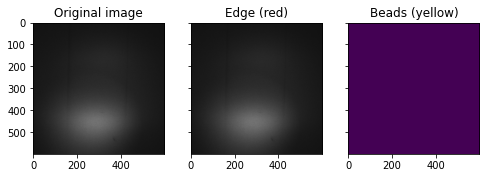

data/img_000000004_Default_000.tif 
 number of beads: 0 
 bead loc, size, intensity,  []


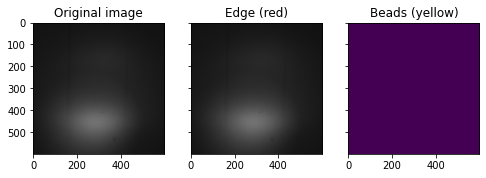

data/img_000000005_Default_000.tif 
 number of beads: 3 
 bead loc, size, intensity,  [((168.8042328042328, 377.27106227106225), 2457, 1.7028939526629558), ((201.77882037533513, 301.7815013404826), 2984, 1.8249754098817978), ((429.92090395480227, 299.22033898305085), 885, 1.3401352323838056)]


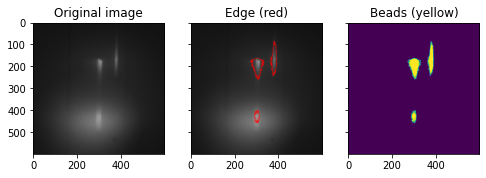

data/img_000000002_Default_000.tif 
 number of beads: 1 
 bead loc, size, intensity,  [((130.04057591623035, 379.7264397905759), 764, 1.5293704210887267)]


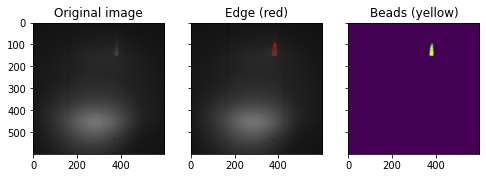

data/img_000000000_Default_000.tif 
 number of beads: 0 
 bead loc, size, intensity,  []


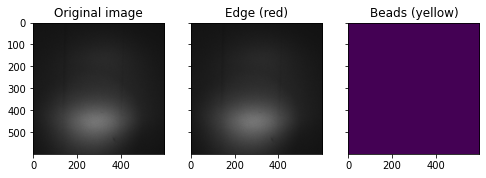

data/img_000000001_Default_000.tif 
 number of beads: 0 
 bead loc, size, intensity,  []


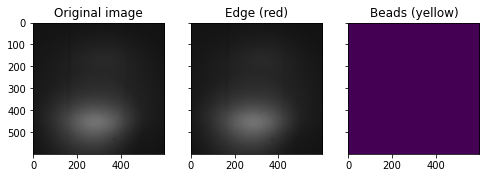

In [4]:
# Plot the image

img_bead_ = {}
color_img = {}
for f in all_files:
    print(f, '\n', 'number of beads:', len(bead_indicator[f]), '\n', 'bead loc, size, intensity, ', bead_info[f])
    fig2, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(8, 4), 
                                sharex=True, sharey=True)
    
    mm = img_bead[f].shape[0]
    nn = img_bead[f].shape[1]
    img_bead_[f] = np.zeros((mm, nn))
    for bead in bead_indicator[f]:
        for pix in bead:
            img_bead_[f][pix[0]][pix[1]] = 1
    
    laplacian = cv2.Laplacian(img_bead_[f],cv2.CV_64F)
    color_img[f] = cv2.cvtColor(img[f], cv2.COLOR_GRAY2RGB)
    
    for i in range(color_img[f].shape[0]):
        for j in range(color_img[f].shape[1]):
            if laplacian[i,j] !=0:
                color_img[f][i,j] = [255, 0, 0]

       
    ax1.set_title('Original image')
    ax1.imshow(cv2.cvtColor(img[f], cv2.COLOR_GRAY2RGB))

    ax2.set_title('Edge (red)')
    ax2.imshow(color_img[f])
    
    ax3.set_title('Beads (yellow)')    
    ax3.imshow(img_bead_[f])

    plt.show()

In [5]:
# Export all bead info as CSV files

import csv
fieldnames = ['frame_number', 'intensity', 'size', 'x location', 'y location']


# beads.csv contains all beads
with open('beads.csv', mode='w') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for f in all_files:
        for bead in bead_indicator[f]:
            int_bead = 0
            for pix in bead:
                int_bead += img[f][pix[0]][pix[1]] / background[pix[0]][pix[1]]
            entry = {'frame_number': int(f.split('_')[1]), 'intensity': int_bead/len(bead), 'size': len(bead), 
                     'x location': np.mean([pix[0] for pix in bead]), 'y location': np.mean([pix[1] for pix in bead])}
            writer.writerow(entry)

# beads_up.csv contains all beads that appear in the upper half of the image plane
with open('beads_up.csv', mode='w') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for f in all_files:
        for bead in bead_indicator[f]:
            x_loc = np.mean([pix[0] for pix in bead])
            if x_loc < 300:
                int_bead = 0
                for pix in bead:
                    int_bead += img[f][pix[0]][pix[1]]  / background[pix[0]][pix[1]]
                entry = {'frame_number': int(f.split('_')[1]), 'intensity': int_bead/len(bead), 'size': len(bead), 
                         'x location': np.mean([pix[0] for pix in bead]), 'y location': np.mean([pix[1] for pix in bead])}
                writer.writerow(entry)

# beads_down.csv contains all beads that appear in the lower half of the image plane
with open('beads_down.csv', mode='w') as csv_file:
    writer = csv.DictWriter(csv_file, fieldnames=fieldnames)
    writer.writeheader()
    for f in all_files:
        for bead in bead_indicator[f]:
            x_loc = np.mean([pix[0] for pix in bead])
            if x_loc > 300:
                int_bead = 0
                for pix in bead:
                    int_bead += img[f][pix[0]][pix[1]] / background[pix[0]][pix[1]]
                entry = {'frame_number': int(f.split('_')[1]), 'intensity': int_bead/len(bead), 'size': len(bead), 
                         'x location': np.mean([pix[0] for pix in bead]), 'y location': np.mean([pix[1] for pix in bead])}
                writer.writerow(entry)



In [6]:
# create a video with all bead edges marked

video_name = 'bead_video.mp4'

height, width, dummy = color_img[f].shape
layers = len(all_files)

fps = 10
video = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'XVID'), fps, (width, height))

for f in all_files:
    video.write(color_img[f])


cv2.destroyAllWindows()
video.release()
